**Function 3:**

Drug Discovery Problem. In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
f3_inputs = np.load("initial_inputs.npy")
f3_outputs = np.load("initial_outputs.npy")
f3_inputs_2 = np.load("initial_inputs2.npy")
f3_outputs_2 = np.load("initial_outputs2.npy")

In [8]:
f3_inputs = np.concatenate((f3_inputs, f3_inputs_2)) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.856453, 0.572658, 0.396564]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.419052, 0.525791, 0.668723]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.806453, 0.542658, 0.426564]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.95404 , 0.603434, 0.360707]])))
f3_inputs = np.concatenate((f3_inputs, np.array([[0.378686, 0.252828, 0.414646]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.872008, 0.592658, 0.394341]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.876453, 0.552658, 0.376564]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.836453, 0.579324, 0.385452]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.867564, 0.561546, 0.416564]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.852008, 0.563768, 0.409897]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.840896, 0.583768, 0.429897]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.756341, 0.548901, 0.444526]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.79493 , 0.426714, 0.384933]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.863119, 0.543768, 0.403231]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.845371, 0.518261, 0.394578]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.872008, 0.543768, 0.429897]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.85423 , 0.561545, 0.40323 ]]))) 
f3_inputs = np.concatenate((f3_inputs, np.array([[0.872008, 0.574879, 0.412119]]))) 

f3_outputs = np.concatenate((f3_outputs,f3_outputs_2)) 
f3_outputs = np.append(f3_outputs,-0.007556472239926157)
f3_outputs = np.append(f3_outputs,-0.11117041024766369)
f3_outputs = np.append(f3_outputs,-0.02486221525774178)
f3_outputs = np.append(f3_outputs,-0.02157038795559339)
f3_outputs = np.append(f3_outputs,-0.0503012651579929)
f3_outputs = np.append(f3_outputs,-0.01517794191050481)
f3_outputs = np.append(f3_outputs,-0.01595053598681603)
f3_outputs = np.append(f3_outputs,-0.010925064020108063)
f3_outputs = np.append(f3_outputs,-0.007386906470204272)
f3_outputs = np.append(f3_outputs,-0.004457685991172721)
f3_outputs = np.append(f3_outputs,-0.025865326752195786)
f3_outputs = np.append(f3_outputs,-0.011107628816793764)
f3_outputs = np.append(f3_outputs,-0.01562544524641375)
f3_outputs = np.append(f3_outputs,-0.010331415655822254)
f3_outputs = np.append(f3_outputs,-0.01698559042276884)
f3_outputs = np.append(f3_outputs,-0.017335638304868072)
f3_outputs = np.append(f3_outputs,-0.01188054501063807)
f3_outputs = np.append(f3_outputs,-0.008744864239247193)


In [9]:
X_max= f3_inputs[np.argmax((f3_outputs))]
print(X_max)

[0.852008 0.563768 0.409897]


In [10]:
Y_max= f3_outputs[np.argmax((f3_outputs))]
print(Y_max)

-0.004457685991172721


In [7]:
def costly_function(x):
    total = np.array([])
    for x_i in x:
         total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total  + np.random.randn()

In [11]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            tmpdf = pd.DataFrame({"y": y_max, "ei": optimal_ei},index=[1])
            #self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
            self.best_samples_ =pd.concat([self.best_samples_ ,tmpdf],ignore_index = True)
        
        return optimal_x, y_max
  
  
        

In [12]:
sample_x = f3_inputs
sample_y = f3_outputs

In [28]:
bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=200, scale=10, batch_size=30)
bopt.optimize()

(array([5.28631774, 4.04208339, 4.53543696]), 5.258058465628174)

In [22]:
f3_inputs

array([[0.17152521, 0.34391687, 0.2487372 ],
       [0.24211446, 0.64407427, 0.27243281],
       [0.53490572, 0.39850092, 0.17338873],
       [0.49258141, 0.61159319, 0.34017639],
       [0.13462167, 0.21991724, 0.45820622],
       [0.34552327, 0.94135983, 0.26936348],
       [0.15183663, 0.43999062, 0.99088187],
       [0.64550284, 0.39714294, 0.91977134],
       [0.74691195, 0.28419631, 0.22629985],
       [0.17047699, 0.6970324 , 0.14916943],
       [0.22054934, 0.29782524, 0.34355534],
       [0.66601366, 0.67198515, 0.2462953 ],
       [0.04680895, 0.23136024, 0.77061759],
       [0.60009728, 0.72513573, 0.06608864],
       [0.96599485, 0.86111969, 0.56682913],
       [0.16569979, 0.25685582, 0.65469   ],
       [0.65099632, 0.42417272, 0.52674437],
       [0.10601263, 0.24333177, 0.65025654],
       [0.35216426, 0.10580766, 0.06546785],
       [0.829086  , 0.4393692 , 0.20713429],
       [0.80489315, 0.31206954, 0.24371441],
       [0.46204056, 0.12939599, 0.83858636],
       [0.

In [23]:
f3_outputs

array([-0.1121222 , -0.08796286, -0.11141465, -0.03483531, -0.04800758,
       -0.11062091, -0.39892551, -0.11386851, -0.13146061, -0.09418956,
       -0.04694741, -0.10596504, -0.11804826, -0.03637783, -0.05675837,
       -0.12809391, -0.03103939, -0.1172756 , -0.07944403, -0.14258557,
       -0.11962132, -0.06119926, -0.03435924, -0.0876973 , -0.11502216,
       -0.07478879, -0.10441561, -0.08945485, -0.08760022, -0.02514614,
       -0.00755647, -0.11117041, -0.02486222, -0.02157039, -0.05030127,
       -0.01517794, -0.01595054, -0.01092506, -0.00738691, -0.00445769,
       -0.02586533, -0.01110763, -0.01562545, -0.01033142])

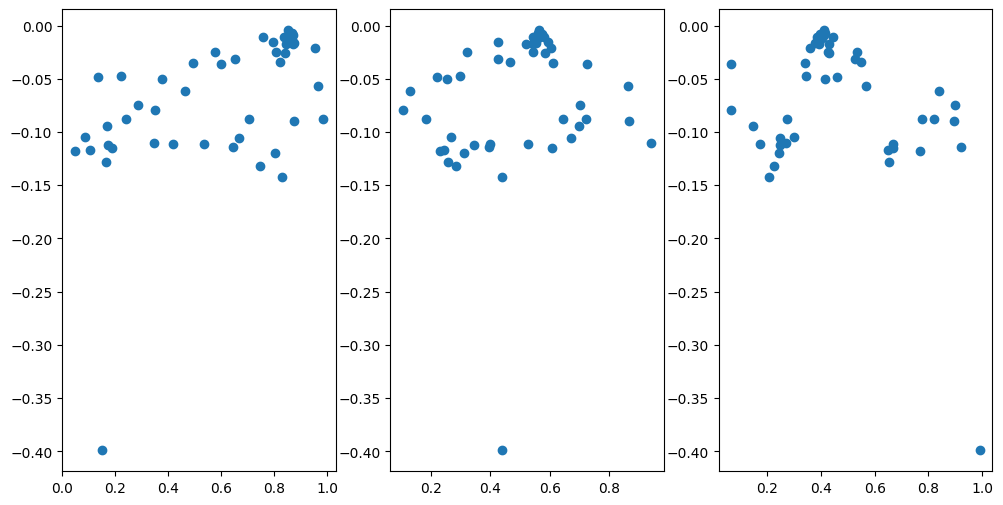

In [11]:
fig, ax = plt.subplots(1,3,figsize = (12,6))
ax[0].scatter(f3_inputs[:,0],f3_outputs)
ax[1].scatter(f3_inputs[:,1],f3_outputs)
ax[2].scatter(f3_inputs[:,2],f3_outputs)
plt.show()